This code is a modified version of @filthyQuants code from tik tok, the original code backtested a 50 day moving average strategy. I have expanded it to consider other strategies such as an exponential moving average, a crossover moving average and and a coin flip strategy.

In [1]:
from backtester import *

If you interested in the way this code works you can find each of the strategies and the code to implement them below. If you aren't scroll down to see the implementation to mess around with the various parameters.

In [2]:
#First we need to retreive the data to do any of the testing against. 

def getdata(stockname,testperiod, datatype, interval1):
    yfdata = yf.Ticker("{}".format(stockname)).history(period=str(testperiod),interval = interval1)
    closedata = yfdata[datatype].copy()
    return closedata

In [3]:
#Defining a function to take the moving cost averages, in this case we will do it over 50 days. The days is letting you set the number of days.

def sma(data_levels,days = 50, tolerance = 0.001):
    
    #First we turn it into a data frame. 
    
    data = pd.DataFrame(data_levels).copy()
    
    #Second we take the data and add a new column that has the moving cost average where we will name the new column SMA with the 
    # subscript of the number of days being considered
    
    data['SMA_{}'.format(days)]  = data.iloc[:,0].rolling(days).mean()
    
    #Create a new column that has a the 'returns', this will be the percentage change day on day of the security. 
    
    data['Returns'] = data.iloc[:,0].pct_change() 
    
    #house keeping to get rid of any empty columns, 
    
    data = data.dropna()
    
    #make a list to store the signal data, 

    signals = []
    
    #loop through the data and if the rolling close average and compares it to the closing price that day. 

    for i in range(len(data)):
        
        ## if Current price + tolerance > SMA = buy
        if data['Close'].iloc[i] + tolerance*data['Close'].iloc[i] > data['SMA_{}'.format(days)].iloc[i]:
            signals.append(1)
        
        # if Current price < SMA tolerance = sell
        elif data['Close'].iloc[i] < data['SMA_{}'.format(days)].iloc[i] +tolerance*data['Close'].iloc[i]:
            signals.append(-1)
            
        # if Current Price is too close to SMA we wont do anything
        else: 
            signals.append(0)
            
    data['Signals'] = signals
    return data

In [4]:
#Defining a function to take the exponential moving cost averages, in this case we will do it over 50 days. The days is letting you set the number of days

def ema(data_levels,days = 50, tolerance = 0.001):
    
    #First we turn it into a data frame. 
    
    data = pd.DataFrame(data_levels).copy()
    
    #make a new column that has exponential weighted average. EWM method in pandas makes this super easy
    
    data['EMA_{}'.format(days)] = data.iloc[:,0].ewm(span = days).mean()   
    
    #Create a new column that has a the 'returns', this will be the percentage change day on day. 
    
    data['Returns'] = data.iloc[:,0].pct_change() 
    
    #house keeping to get rid of any empty rows, 
    
    data = data.dropna()
    
    #make a list to store the signal data, 

    signals = []
    
    #loop through the data and if the rolling close average and compares it to the closing price that day. 

    for i in range(len(data)):
        
        ## if Current price > EMA + tolerance = buy
        if data['Close'].iloc[i] > data['EMA_{}'.format(days)].iloc[i] + tolerance*data['Close'].iloc[i]:
            signals.append(1)
        
        # if if Current price + tolerance < EMA = sell
        elif data['Close'].iloc[i] + tolerance*data['Close'].iloc[i]< data['EMA_{}'.format(days)].iloc[i]:
            signals.append(-1)
            
        # if EMA is too close to current price = do nothing
        else: 
            signals.append(0)
            
    data['Signals'] = signals 
    
    return data

In [5]:
#Defining a function to find the signals of a moving crossover strategy

def mxa(data_levels,daysshort = 50, dayslong =200, tolerance = 0.001):
    
    #First we turn it into a data frame. 
    
    data = pd.DataFrame(data_levels).copy()
    
    #make a new collumn that has the 50 day average
    
    data['SMA_{}'.format(daysshort)]  = data.iloc[:,0].rolling(daysshort).mean()
    
    #make another that has the 200 day average 
    
    data['SMA_{}'.format(dayslong)]  = data.iloc[:,0].rolling(dayslong).mean()
    
    #Create a new collumn that has a the 'returns', this will be the percentage change day on day of the security. 
    
    data['Returns'] = data.iloc[:,0].pct_change() 
    
    #house keeping to get rid of any empty rows, 
    
    data = data.dropna()
    
    #make a list to store the signal data, 

    signals = []
    
    #loop through ther data and if the rolling close average and compares it to the closing price that day. 

    for i in range(len(data)):
        
        ## if 50 day average > 200 day average +tolerance = buy
        if data['SMA_{}'.format(daysshort)].iloc[i] > data['SMA_{}'.format(dayslong)].iloc[i]+ tolerance*data['Close'].iloc[i]:
            signals.append(1)
        
        # if 50 day average +tolerance < 200 day average = sell
        elif data['SMA_{}'.format(daysshort)].iloc[i] + tolerance*data['Close'].iloc[i] < data['SMA_{}'.format(dayslong)].iloc[i]:
            signals.append(-1)
            
        # if the two averages are close to one another then we wont do anything
        else:
            signals.append(0)
            
    data['Signals'] = signals
    
    return data

In [6]:
def rsi(data_levels, rsi_days = 14 , overbought= 70, oversold =30):
    
    #First we turn it into a data frame. 
    
    data = pd.DataFrame(data_levels).copy()
    data = data.dropna()
    
    #we also need a percentage change column so we can split the gains and losses     
    
    data['Returns'] = data.iloc[:,0].pct_change() 
    
    #next we are going to make two collumns one for the gains one for the losses,
    #we are trying to avoid doing this in for loops so that it is a bit quicker
        
    data['gains'] = data['Returns'].apply(lambda x: x if x>0 else 0)
    
    data['losses'] = data['Returns'].apply(lambda x: -x if x<0 else 0)
    
    #then we need the exponential average losses and gains so that we can calculate the RS of the stock this is for the initial values
    
    data['ema_gain'] = data['gains'].ewm(span=rsi_days, min_periods=rsi_days).mean()
    data['ema_loss'] = data['losses'].ewm(span=rsi_days, min_periods=rsi_days).mean()
    
    #then calculate the reletive strength after each close
    
    data['rs'] = data['ema_gain']/data['ema_loss']
    
    #Work out the RSI in every given period 
    
    data['RSI_{}'.format(rsi_days)] = (100-(100/ (data['rs'] +1)))
    
    #A blank list for the signals to go

    signals = []
       
    #now we need to loop through the data to produce the signals
    
    for i in range(len(data)):
        
        #if the RSI goes above our below then we will buy as we expect an upturn

        if data['RSI_{}'.format(rsi_days)].iloc[i] < oversold:
            signals.append(1)
            
        #if the RSI goes above our threshold we sell
        
        elif data['RSI_{}'.format(rsi_days)].iloc[i] > overbought:
            signals.append(-1)
            
        #else we hold, note that in the first 14 days there wont be any kind of data because the formula doesn't work till day 14
        
        else:
            signals.append(0)
    data['Signals'] = signals
    return data

In [7]:
def randomtrading(data_levels, probabilitybuy = 0.5, probabilitysell = 0.5,probabilitydonothing= 0):
    
    #first just clean up the data so there are no differencs with the above code.
    
    data = pd.DataFrame(data_levels).copy()
    data = data.dropna()

    #adding this if in so that we make sure the probabilities actually add up to 1
    
    if probabilitybuy+probabilitydonothing+probabilitysell <= 1 :
        
        #make a list to store the signals
        
        randomsignals = []
        
        #loop over the signals and for the buy sell probability if the random number is below the probility threshold we buy, or the probability we 
        
        for i in range(len(data)):
            p = random.random()
            if p<probabilitybuy:
                randomsignals.append(1)
            elif p<probabilitybuy + probabilitysell:
                randomsignals.append(-1)
            elif p >probabilitybuy + probabilitysell:
                randomsignals.append(0)
        data['Signals'] = randomsignals
    else:
        print("probabilities did not sum to 1 or less ")
        randomsignals = np.zeros(len(data))
        data['Signals'] = randomsignals
        
    return data

In [8]:

def runthetests():
    #running through the four different tests and outputting the win rate final returns and making a graph of the 
    # short simple average, long simple average, exponential average as a graph against close price.
    
    #first thing to do is pull the data from Yahoo finance
    
    closedata = getdata(stockname,testperiod,datatype,interval1)
    
    #Then run it through the various different strategies
    
    #First SMA

    dfsma = sma(closedata, days = shortdays, tolerance= toll)
    retrunssma = backtester(dfsma['Signals'],dfsma['Close'], tcost )
    retrunssma.plot(xlabel = 'year', ylabel = 'return', title = 'Return using the moving simple moving average strategy {}'.format(stockname),figsize = (25,10))
    print('Winrate of SMA '+ str(winrate(dfsma,retrunssma)))
    print('Final return of SMA '+ str(retrunssma.iloc[-1][0]))
    print('Sharpe ratio of SMA '+ str(Sharperatio(retrunssma,tradingdays=tradingdays,rrr=rrr )[0]))
    
    #Second EMA

    dfema = ema(closedata, days = shortdays, tolerance= toll)
    retrunsema = backtester(dfema['Signals'],dfema['Close'], tcost )
    retrunsema.plot(xlabel = 'year', ylabel = 'return', title = 'Return using the moving expoenential average strategy {}'.format(stockname),figsize = (25,10))
    print('Winrate of EMA '+ str(winrate(dfema,retrunsema)))
    print('Final return of EMA '+ str(retrunsema.iloc[-1][0]))
    print('Sharpe ratio of EMA '+ str(Sharperatio(retrunsema,tradingdays=tradingdays,rrr=rrr )[0]))
    
    #third moving cross over strategy

    dfmxa = mxa(closedata,daysshort = 50, dayslong =longdays, tolerance = toll)
    returnsxma = backtester(dfmxa['Signals'],dfmxa['Close'], tcost )
    returnsxma.plot(xlabel = 'year', ylabel = 'return', title = 'Return using the moving crossover strategy {}'.format(stockname),figsize = (25,10))
    print('Winrate of XMA '+ str(winrate(dfmxa,returnsxma)))
    print('Final return of XMA '+ str(returnsxma.iloc[-1][0]))
    print('Sharpe ratio of XMA '+ str(Sharperatio(returnsxma,tradingdays=tradingdays,rrr=rrr )[0]))
    
    #fourth the RSI strategy
    
    dfrsi = rsi(closedata, rsi_days=rsi_period , overbought=overbuy, oversold=oversell)
    returnsrsi = backtester(dfrsi['Signals'], dfrsi['Close'], tcost)
    returnsrsi.plot(xlabel = 'year', ylabel = 'return', title = 'Return RSI strategy {}'.format(stockname),figsize = (25,10))
    dfrsi['RSI_{}'.format(rsi_period)].plot(xlabel = 'year', ylabel = ('RSI_{}'.format(rsi_period)), title = ('RSI indicator over {} days'.format(rsi_period)),figsize = (25,10))
    print('Winrate of RSI '+ str(winrate(dfrsi,returnsrsi)))
    print('Final return of RSI '+ str(returnsrsi.iloc[-1][0]))
    print('Sharpe ratio of RSI '+ str(Sharperatio(returnsrsi,tradingdays=tradingdays,rrr=rrr )[0]))   
    
    #fifth Random coin flips

    dfrandom = randomtrading(closedata, probabilitybuy= probbuy,probabilitysell = probsell, probabilitydonothing = probdonothing )
    returnsrandom = backtester(dfrandom['Signals'],dfrandom['Close'], tcost )
    returnsrandom.plot(xlabel = 'year', ylabel = 'return', title = 'Return using the coinflip strategy {}'.format(stockname),figsize = (25,10))
    print('Winrate of coinflips '+ str(winrate(dfrandom,returnsrandom)))
    print('Final return of coinflips  '+ str(returnsrandom.iloc[-1][0]))
    print('Sharpe ratio of coinflips '+ str(Sharperatio(returnsrandom,tradingdays=tradingdays,rrr=rrr )[0]))  

    #put all of the indicators together to make one big graph against the actual close price

    data = pd.DataFrame(closedata).copy()
    data['EMA_{}'.format(shortdays)] = data.iloc[:,0].ewm(span = shortdays).mean()
    data['SMA_{}'.format(shortdays)]  = data.iloc[:,0].rolling(shortdays).mean()
    data['SMA_{}'.format(longdays)]  = data.iloc[:,0].rolling(longdays).mean()

    data[['Close','SMA_{}'.format(shortdays),'SMA_{}'.format(longdays),'EMA_{}'.format(shortdays)]].plot(xlabel = 'year', ylabel = 'USD', title = '{}'.format(stockname) ,figsize = (20,10))


Actually backtesting the code.

Winrate of SMA 0.5559633027522936
Final return of SMA 130.92190258218574
Sharpe ratio of SMA -2.0917010989254705
Winrate of EMA 0.5511571254567601
Final return of EMA 76.7547552485559
Sharpe ratio of EMA -2.0495036829908573
Winrate of XMA 0.5478881618084473
Final return of XMA 73.81548049789363
Sharpe ratio of XMA -1.180604459846861
Winrate of RSI 0.1323529411764706
Final return of RSI 20.93960064933714
Sharpe ratio of RSI -0.09435232777480541
Winrate of coinflips 0.48084147257700977
Final return of coinflips  8.845827078720315
Sharpe ratio of coinflips -1.4511528158886824


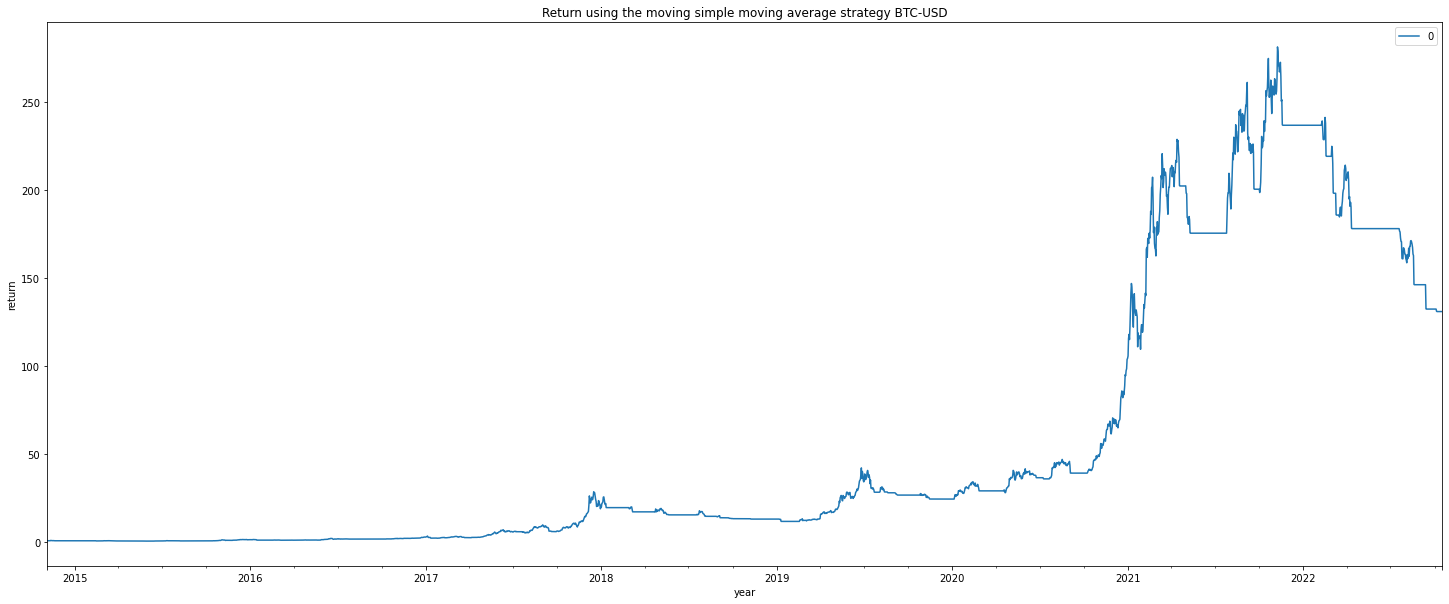

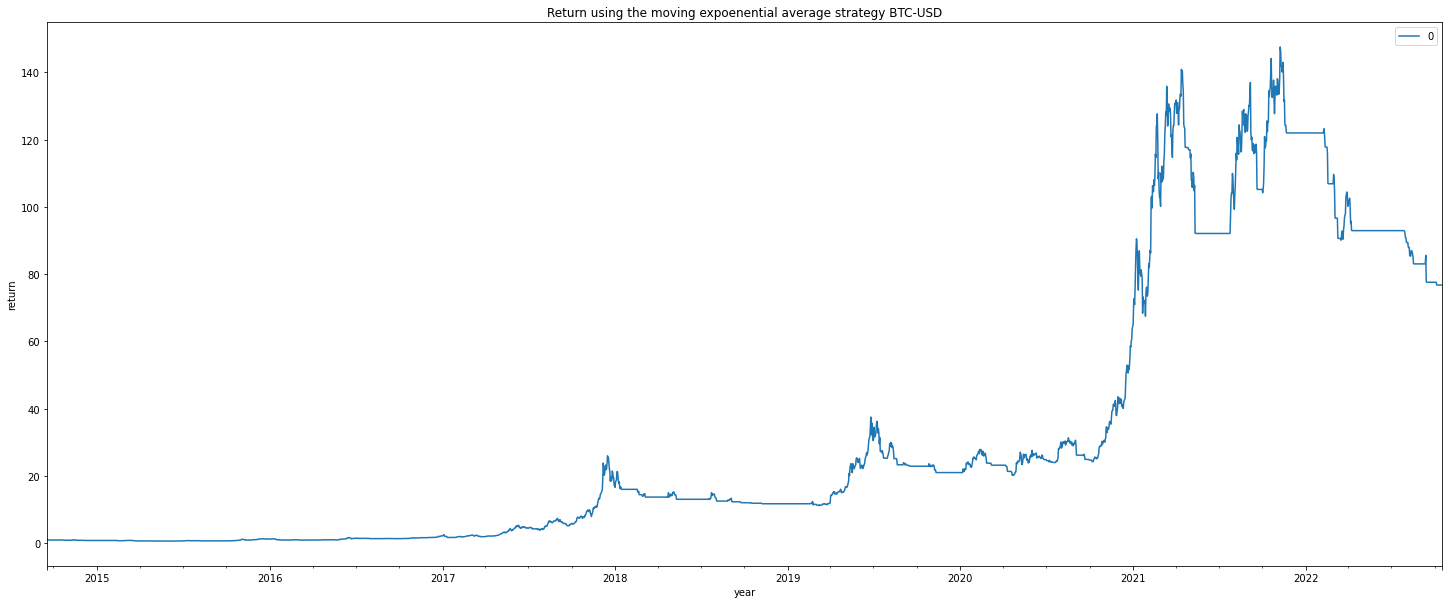

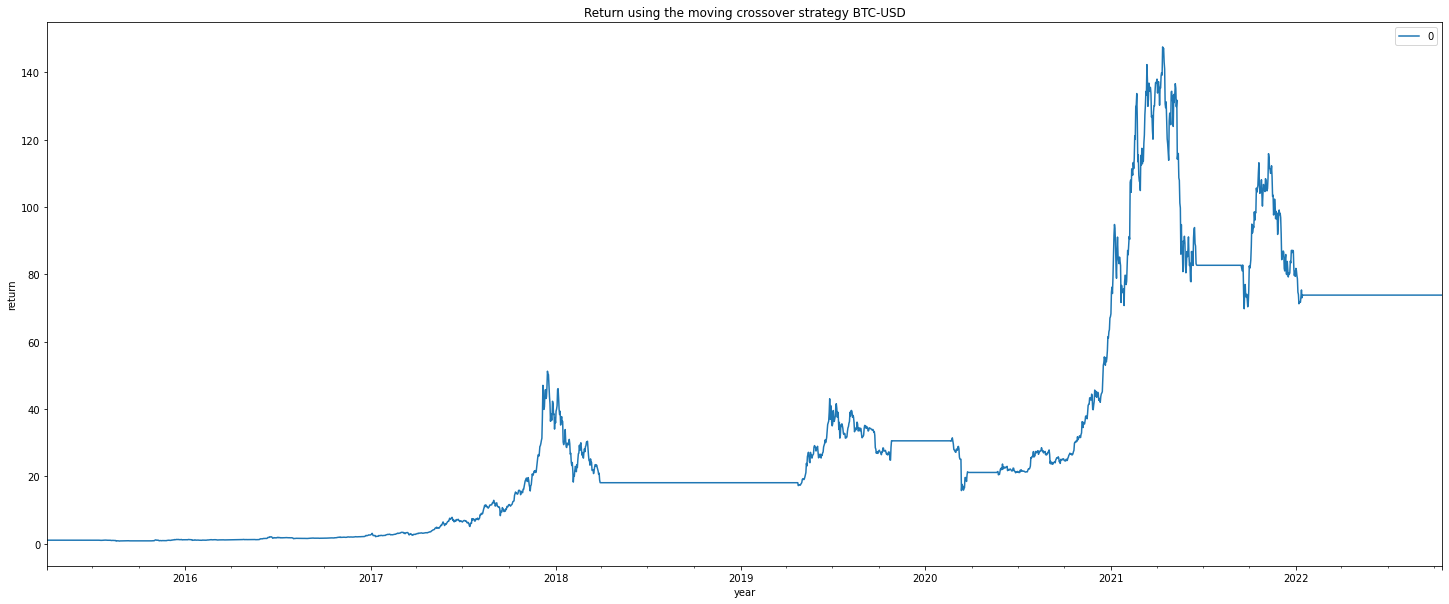

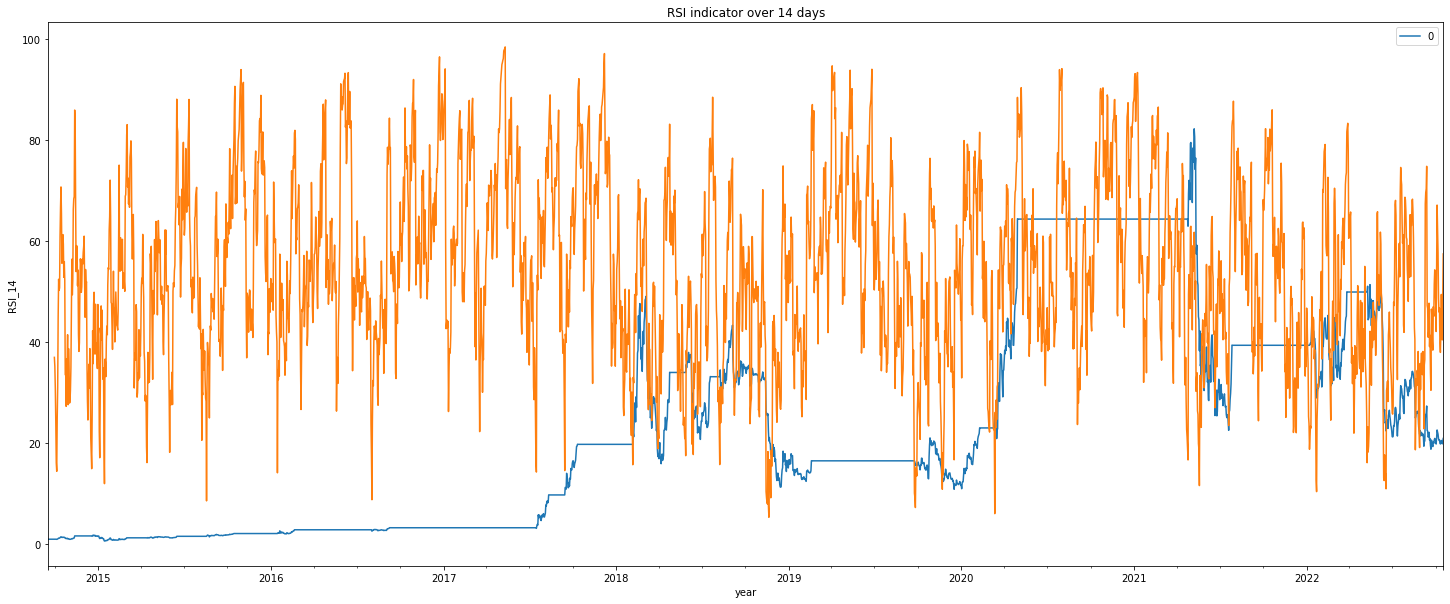

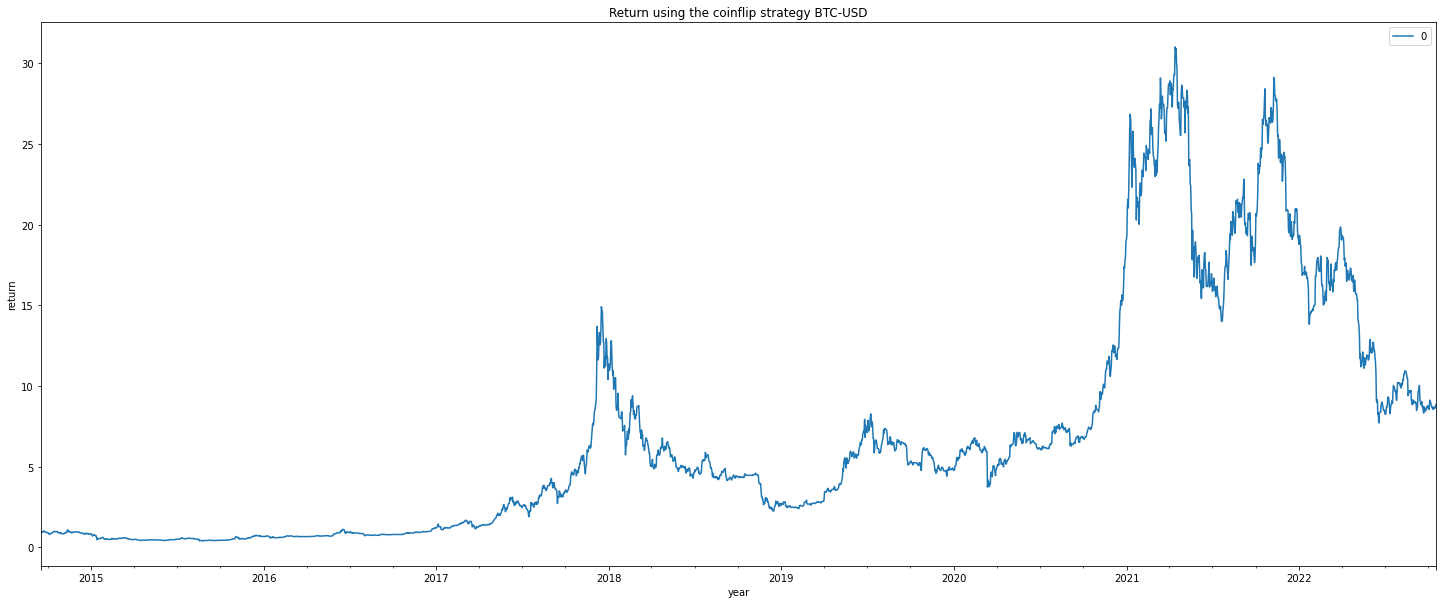

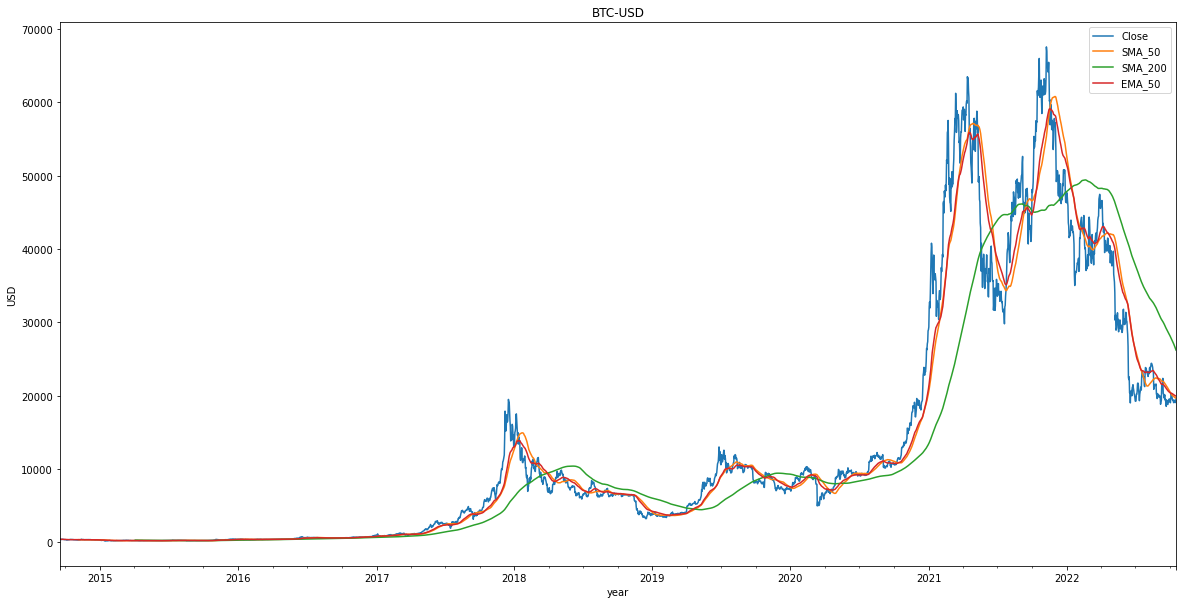

In [9]:
#now lets check the four strategies that have been encoded above to compare them, this cell once the parameters are entered will run 
#this cell let you define all of the probabilities we will be calling on 

#select the stock or coin that you want to back test against and the data point from each day i.e. 'Open','Close','High'etc 

stockname = "BTC-USD"

testperiod = "30y"

datatype= 'Close'

interval1 = '1D'

# This is going to be used as the "risk free" rate of return, as default it is set to 2%, as a fair rate of return
#Given that this is an annualized rate of return, it will only consider the last year of data

rrr = 0.01

# This is the number of days that the security from above is traded, it might be 365 if it is traded every day or 255 otherwise

tradingdays = 365

#then define the transaction cost 

tcost = 0.001

#define the short averaging period used in SMA EMA and XMA note that this is in the units of the interval, so if it is in weeks it will apply over weeks, for days it will apply over days etc.

shortdays = 50 

#define the long period used in MXA

longdays = 200

# define a tolerance variable, this says by just how much the the averages need to be above or below the close in the case of SMA and EMA price to execute a trade
# This is tolerance is set as a proportion of the close price that day. 
#set to zero remove it

toll = 0.00

#define the RSI period, typically 14 is used 

rsi_period = 14

#this is the threshold for the rsi indicator that tells you to sell, if the rsi goes over this limit then the theory says that the stock is being sold and is due to revert back the mean. 

overbuy = 80

#this is the threshold for the rsi indicator that tells you to sell, if the rsi indicator goes below this number then the theory says that ht stock is being over sold and is due to increase in price this number should be lower than the over buy limit

oversell = 20

#lastly for the coin flip the probability of buying, probability of selling and the probability of doing nothing taken as the difference between probbuy +probsell and 1 

probbuy = 9/10

probsell = 1/10

probdonothing = 0

runthetests()

Given that flipping a coin is random process lets test it a 1000 times just to be sure that we didn't just have a very unlucky series of rolls


The average return is: 781.1884695789631
the average win rate is: 0.5355706580828263


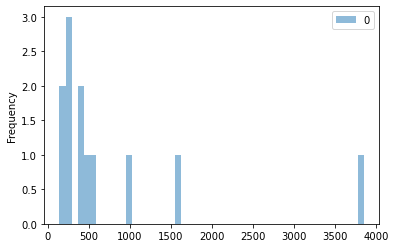

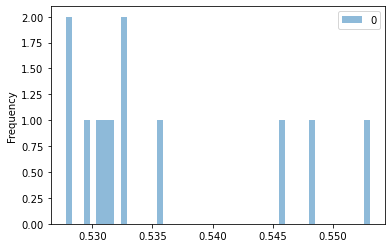

In [10]:

#run the random trial a bunch of times times just to be sure

data_type = 'Close'

interval1 = '1d'

numoftrials = 12

probbuy = 0.5

probsell = 0.000001

probdonothing = 0

finalreturns = []

runningtotalwinrate = []

#get the data 

data = getdata(stockname, testperiod, data_type, interval1)

#experimental jit multithreading, not currently working because pandas data frames don't work well with jit

#@jit(nogil=True, parallel=True)

def runrandomtrials(trails = 1000):
    for j in range(trails):
        dfrandoms = randomtrading(data, probabilitybuy= probbuy,probabilitysell = probsell, probabilitydonothing = probdonothing ) 
        returnsrandom = backtester(dfrandoms['Signals'],dfrandoms['Close'])
        win = winrate(dfrandoms,returnsrandom)
        finalreturns.append(returnsrandom.iloc[-1])
        runningtotalwinrate.append(win)

#call the function

runrandomtrials(numoftrials)

# the average final return 

print('The average return is: ' + str(sum(pd.DataFrame(finalreturns)[0]/numoftrials)) )

# the average win rate

print('the average win rate is: ' + str(sum(runningtotalwinrate)/numoftrials))

#plotting a histogram to show the final returns and then the win rates

axfinalreturns = pd.DataFrame(finalreturns)[:].plot.hist(bins=50, alpha=0.5)
axwinrates = pd.DataFrame(runningtotalwinrate).plot.hist(bins=50, alpha=0.5)